###Objetivo do projeto:
A proposta inicial do trabalho consiste em analisar o hitórico do desempenho de algumas empresas brasileiras listadas na bolsa de valores, e a partir disso desenvolver um modelo capaz de apontar se devemos comprar ação de determinada empresa ou vender,e no final, obter uma carteira de rendimentos que seja mais lucrativa que o índice Ibovespa

In [ ]:
# Intalação de pacotes
%%capture
!pip install pandas_datareader # pacote para a leitura das cotações
!pip install yfinance # pacote para leitura das ações

In [ ]:
# Importação de pacotes
import yfinance as yf # função para pegar as cotações
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

###Passo 1
Criar dicionários de Dataframes com cada empresa

In [ ]:
%%capture
# Lista de empresas escolhidas para analisar
empresas = ["ABEV3", "AZUL4", "B3SA3", "BBSE3", "BBDC4", "BRAP4", "BBAS3", "BRKM5", "BRFS3", "BPAC11", "CRFB3", "CCRO3", "CMIG4", "CIEL3", "COGN3", "CPLE6", "CSAN3",
            "CPFE3", "CVCB3", "CYRE3", "ECOR3", "ELET6", "EMBR3", "ENBR3", "ENGI11", "ENEV3", "EGIE3", "EQTL3", "EZTC3", "FLRY3", "GGBR4", "GOAU4", "GOLL4", "NTCO3",
            "HAPV3", "HYPE3", "ITSA4", "ITUB4", "JBSS3", "JHSF3", "KLBN11", "RENT3", "LREN3", "MGLU3", "MRFG3", "BEEF3", "MRVE3", "MULT3", "PCAR3", "PETR4", "PRIO3",
            "QUAL3", "RADL3", "RAIL3", "SBSP3", "SANB11", "CSNA3", "SUZB3", "TAEE11", "VIVT3", "TIMS3", "TOTS3", "UGPA3", "USIM5", "VALE3", "WEGE3", "YDUQ3"]

# Dicionário de fundamentos
fundamentos = {}

# Leitura dos arquivos com os balanços das empresas (foram baixados arquivos em excel previamente com relatórios de cada uma das empresas. fonte: https://www.fundamentus.com.br/)
arquivos = os.listdir('/content/drive/MyDrive/Projetos pessoais/balancos')

for arquivo in arquivos:
  nome = arquivo[-9:-4]
  if '11' in nome:
    nome = arquivo[-10:-4]
  if nome in empresas:
    print(nome)
    # pegar o balanço da empresa
    balanco = pd.read_excel(f'/content/drive/MyDrive/Projetos pessoais/balancos/{arquivo}', sheet_name=0)
    # na primeira coluna colocar o título com o nome da empresa
    balanco.iloc[0,0] = nome
    # pegar a 1° linha e tornar um cabeçalho
    balanco.columns = balanco.iloc[0]
    balanco = balanco[1:]
    # tornar a 1° coluna o índice da tabela (que agora tem o nome da empresa)
    balanco = balanco.set_index(nome)

    # pegar o dre da empresa
    dre = pd.read_excel(f'/content/drive/MyDrive/Projetos pessoais/balancos/{arquivo}', sheet_name=1)
    # na primeira coluna colocar o título com o nome da empresa
    dre.iloc[0,0] = nome
    # pegar a 1° linha e tornar um cabeçalho
    dre.columns = dre.iloc[0]
    dre = dre[1:]
    # tornar a 1° coluna o índice da tabela (que agora tem o nome da empresa)
    dre = dre.set_index(nome)

    # adição dos dados dentro do dicionário
    fundamentos[nome] = balanco.append(dre)


In [ ]:
# Visualização do dicionário de fundamentos:
fundamentos

{'ABEV3': 0                                           31/03/2023     31/12/2022  \
 ABEV3                                                                   
 Ativo Total                               135466721.28  137958080.512   
 Ativo Circulante                              35378688   37816713.216   
 Caixa e Equivalentes de Caixa             12214085.632   14926435.328   
 Aplicações Financeiras                          365284     454496.992   
 Contas a Receber                           5046681.088    5349105.152   
 ...                                                ...            ...   
 IR Diferido                                 791542.016    -849852.032   
 Participações/Contribuições Estatutárias           NaN            NaN   
 Reversão dos Juros sobre Capital Próprio           NaN            NaN   
 Part. de Acionistas Não Controladores          -119674        -116528   
 Lucro/Prejuízo do Período                   3699575.04     4966871.04   
 
 0                         

### Passo 2
Pegar os preços das ações nas datas correspondentes

In [ ]:
%%capture
# Df vazio para receber acumular as cotações
cotacoes_df = pd.DataFrame()

# Loop para coletar as cotações
for empresa in empresas:
    print(empresa)
    cotacoes_empresa = yf.download(f'{empresa}.SA')
    cotacoes_empresa['Empresa'] = empresa
    cotacoes_df = pd.concat([cotacoes_df, cotacoes_empresa])

# Trasnformando o índice de data, em uma coluna
cotacoes_df.reset_index(inplace=True)
cotacoes_df.rename(columns={'index': 'Date'}, inplace=True)

# Para o mercado de ações, não há operações em feriados e fins de semana
# Porém, os relatórios das empresas são fechados sempre no último dia do mês
# Portanto, é necessário incluir o último dia de cada mês no df de cotações, para completar a análise
# Em caso de feriado ou fim de semana no último dia do mês, a data recebe valores iguais ao do dia anterior

# Converter a coluna "Date" para o formato de data
cotacoes_df['Date'] = pd.to_datetime(cotacoes_df['Date'])

# Criar um índice de data para o DataFrame
cotacoes_df.set_index('Date', inplace=True)

# Agrupar os dados por empresa e fazer o resample para inserir as datas ausentes
dfs_empresas = []
for empresa, df_empresa in cotacoes_df.groupby('Empresa'):
    df_empresa = df_empresa.resample('D').ffill()
    dfs_empresas.append(df_empresa)

# Concatenar os DataFrames de volta em um DataFrame final
cotacoes_df_final = pd.concat(dfs_empresas).reset_index()

# Ordenar novamente pelo nome da empresa e data
cotacoes_df_final = cotacoes_df_final.sort_values(by=['Empresa', 'Date'])

# Criação de dicionário para as cotações
cotacoes = {}
for empresa in cotacoes_df['Empresa'].unique():
    cotacoes[empresa] = cotacoes_df_final.loc[cotacoes_df_final['Empresa'] == empresa, :]


In [ ]:
# Visualização dicionário com o hitórico de cotações das empresas
cotacoes

{'ABEV3':            Date       Open       High        Low      Close  Adj Close  \
 0    2000-01-05   0.520882   0.520882   0.520882   0.520882   0.305528   
 1    2000-01-06   0.494478   0.494478   0.494478   0.494478   0.290040   
 2    2000-01-07   0.494478   0.494478   0.494478   0.494478   0.290040   
 3    2000-01-08   0.494478   0.494478   0.494478   0.494478   0.290040   
 4    2000-01-09   0.494478   0.494478   0.494478   0.494478   0.290040   
 ...         ...        ...        ...        ...        ...        ...   
 8597 2023-07-20  14.750000  14.990000  14.490000  14.920000  14.920000   
 8598 2023-07-21  14.880000  15.470000  14.880000  15.300000  15.300000   
 8599 2023-07-22  14.880000  15.470000  14.880000  15.300000  15.300000   
 8600 2023-07-23  14.880000  15.470000  14.880000  15.300000  15.300000   
 8601 2023-07-24  15.220000  15.370000  15.010000  15.120000  15.120000   
 
         Volume Empresa  
 0          985   ABEV3  
 1          227   ABEV3  
 2         

### Passo 3
Tratamento de dados e junção dos fundamentos com as cotações

In [ ]:
# Para cotações, as datas serão transformadas em índice
# Para fundamentos:
# as linhas se tornaram colunas
# tratamento das datas
# junção das cotações (Adj Close)

for empresa in fundamentos:
  tabela = fundamentos[empresa].T
  tabela.index =pd.to_datetime(tabela.index, format = '%d/%m/%Y')
  tabela_cotacao = cotacoes[empresa].set_index('Date')
  tabela_cotacao = tabela_cotacao[['Adj Close']]

  tabela = tabela.merge(tabela_cotacao, right_index=True, left_index=True)
  tabela.index.name = empresa
  fundamentos[empresa] = tabela

In [ ]:
# Visualização do tratamento para uma das empresas
display(fundamentos['ABEV3'])

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber,Estoques,Ativos Biológicos,Tributos a Recuperar,Despesas Antecipadas,Outros Ativos Circulantes,...,Receitas,Despesas,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Participações/Contribuições Estatutárias,Reversão dos Juros sobre Capital Próprio,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Adj Close
ABEV3,,,,,,,,,,,,,,,,,,,,,
2023-03-31,135466721.28,35378688,12214085.632,365284,5046681.088,13030878.208,0,3049643.008,672673.024,999441.984,...,NaN,NaN,3877664,-849956.992,791542.016,NaN,NaN,-119674,3699575.04,14.330000
2022-12-31,137958080.512,37816713.216,14926435.328,454496.992,5349105.152,12923025.408,0,2853475.072,499779.008,810395.008,...,NaN,NaN,4327530.496,1605720.064,-849852.032,NaN,NaN,-116528,4966871.04,14.520000
2022-09-30,142063960.064,41556963.328,17712654.336,1347216,5386512.896,12495091.712,0,2708019.968,567486.016,1339984,...,NaN,NaN,2803902.976,-872636.032,1283739.008,NaN,NaN,-106450,3108556.032,14.762184
2022-06-30,136633409.536,38238560.256,14129258.496,1535714.048,4771365.888,12587718.656,0,3234363.904,572380.992,1407758.976,...,NaN,NaN,3538621.952,-2189517.056,1714942.976,NaN,NaN,-94304,2969743.872,12.729296
2022-03-31,127399919.616,34479796.224,12887921.664,1345730.048,4383950.848,11426296.832,0,2589875.968,572552,1273469.056,...,NaN,NaN,3565614.08,-262376,225600,NaN,NaN,-116066,3412772.096,14.629190
2021-12-31,138602479.616,38627139.584,16627697.664,1914606.976,4791633.92,11000345.6,0,2612673.024,524140.992,1156041.984,...,NaN,NaN,4104207.616,1025285.952,-1382519.936,NaN,NaN,-139731.024,3607241.728,14.648190
2021-09-30,135133249.536,38197080.064,17956171.776,2044573.952,4512635.904,9511235.584,0,2025905.024,495089.984,1651469.952,...,NaN,NaN,3122459.904,-978081.984,1568338.944,NaN,NaN,-160184.992,3552531.968,13.988282
2021-06-30,124440133.632,32705665.024,13269346.304,1245607.04,3702152.96,9583373.312,0,2865117.952,478539.008,1561529.984,...,NaN,NaN,3617084.928,-799849.024,112345,NaN,NaN,-43799,2885782.016,15.606534
2021-03-31,133417828.352,37059858.432,17286068.224,2049628.032,3357889.024,9698229.248,0,3005978.112,360712,1301357.056,...,NaN,NaN,2915407.872,-515992,333895.008,NaN,NaN,-107899,2625412.096,13.979139


### Passo 4
Remoção de empresas que possuem campos diferentes da maioria

In [ ]:
colunas = list(fundamentos['ABEV3'].columns)

# Lista para armazenar empresas inválidas a serem removidas
empresas_invalidas = []

# Loop para fazer a verificação das empresas
for empresa in empresas:
    if empresa not in fundamentos:
        empresas_invalidas.append(empresa)
    elif set(colunas) != set(fundamentos[empresa].columns):
        empresas_invalidas.append(empresa)

# Removendo as empresas inválidas do dicionário fundamentos
for empresa_invalida in empresas_invalidas:
    fundamentos.pop(empresa_invalida, None)

### Passo 5
Ajeitando campos que possuem nomes iguais

In [ ]:
print(colunas)

['Ativo Total', 'Ativo Circulante', 'Caixa e Equivalentes de Caixa', 'Aplicações Financeiras', 'Contas a Receber', 'Estoques', 'Ativos Biológicos', 'Tributos a Recuperar', 'Despesas Antecipadas', 'Outros Ativos Circulantes', 'Ativo Realizável a Longo Prazo', 'Aplicações Financeiras Avaliadas a Valor Justo', 'Aplicações Financeiras Avaliadas ao Custo Amortizado', 'Contas a Receber', 'Estoques', 'Ativos Biológicos', 'Tributos Diferidos', 'Despesas Antecipadas', 'Créditos com Partes Relacionadas', 'Outros Ativos Não Circulantes', 'Investimentos', 'Imobilizado', 'Intangível', 'Diferido', 'Passivo Total', 'Passivo Circulante', 'Obrigações Sociais e Trabalhistas', 'Fornecedores', 'Obrigações Fiscais', 'Empréstimos e Financiamentos', 'Passivos com Partes Relacionadas', 'Dividendos e JCP a Pagar', 'Outros', 'Provisões', 'Passivos sobre Ativos Não-Correntes a Venda e Descontinuados', 'Passivo Não Circulante', 'Empréstimos e Financiamentos', 'Passivos com Partes Relacionadas', 'Outros', 'Tributo

In [ ]:
texto_colunas = ';'.join(colunas)

# lista auxiliar para receber os campos que foram alterados
colunas_modificadas = []

for coluna in colunas:
  # diferenciação de campos com nomes iguais
  if colunas.count(coluna) == 2 and coluna not in colunas_modificadas:
    texto_colunas = texto_colunas.replace(';' + coluna + ';', ';' + coluna + '_1;', 1)
    colunas_modificadas.append(coluna)

colunas = texto_colunas.split(';')
print(colunas)

['Ativo Total', 'Ativo Circulante', 'Caixa e Equivalentes de Caixa', 'Aplicações Financeiras', 'Contas a Receber_1', 'Estoques_1', 'Ativos Biológicos_1', 'Tributos a Recuperar', 'Despesas Antecipadas_1', 'Outros Ativos Circulantes', 'Ativo Realizável a Longo Prazo', 'Aplicações Financeiras Avaliadas a Valor Justo', 'Aplicações Financeiras Avaliadas ao Custo Amortizado', 'Contas a Receber', 'Estoques', 'Ativos Biológicos', 'Tributos Diferidos_1', 'Despesas Antecipadas', 'Créditos com Partes Relacionadas', 'Outros Ativos Não Circulantes', 'Investimentos', 'Imobilizado', 'Intangível', 'Diferido', 'Passivo Total', 'Passivo Circulante', 'Obrigações Sociais e Trabalhistas', 'Fornecedores', 'Obrigações Fiscais', 'Empréstimos e Financiamentos_1', 'Passivos com Partes Relacionadas_1', 'Dividendos e JCP a Pagar', 'Outros_1', 'Provisões_1', 'Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1', 'Passivo Não Circulante', 'Empréstimos e Financiamentos', 'Passivos com Partes Relacionadas'

In [ ]:
# implementação das colunas nas tabelas
for empresa in fundamentos:
  fundamentos[empresa].columns = colunas

### Passo 6
Tratamento de valores vazios

In [ ]:
# crição de dicionário auxiliar
valores_vazios = dict.fromkeys(colunas, 0)
total_linhas = 0

# verificação da quantidade de linhas com valores vazios
for empresa in fundamentos:
  tabela = fundamentos[empresa]
  total_linhas += tabela.shape[0]
  for coluna in colunas:
    qtde_vazios = pd.isnull(tabela[coluna]).sum()
    valores_vazios[coluna] += qtde_vazios

print(valores_vazios)
print(total_linhas)

{'Ativo Total': 0, 'Ativo Circulante': 0, 'Caixa e Equivalentes de Caixa': 0, 'Aplicações Financeiras': 0, 'Contas a Receber_1': 0, 'Estoques_1': 0, 'Ativos Biológicos_1': 0, 'Tributos a Recuperar': 0, 'Despesas Antecipadas_1': 0, 'Outros Ativos Circulantes': 0, 'Ativo Realizável a Longo Prazo': 0, 'Aplicações Financeiras Avaliadas a Valor Justo': 0, 'Aplicações Financeiras Avaliadas ao Custo Amortizado': 0, 'Contas a Receber': 0, 'Estoques': 0, 'Ativos Biológicos': 0, 'Tributos Diferidos_1': 0, 'Despesas Antecipadas': 0, 'Créditos com Partes Relacionadas': 0, 'Outros Ativos Não Circulantes': 0, 'Investimentos': 0, 'Imobilizado': 0, 'Intangível': 0, 'Diferido': 0, 'Passivo Total': 0, 'Passivo Circulante': 0, 'Obrigações Sociais e Trabalhistas': 0, 'Fornecedores': 0, 'Obrigações Fiscais': 0, 'Empréstimos e Financiamentos_1': 0, 'Passivos com Partes Relacionadas_1': 0, 'Dividendos e JCP a Pagar': 0, 'Outros_1': 0, 'Provisões_1': 0, 'Passivos sobre Ativos Não-Correntes a Venda e Descontin

In [ ]:
# lista auxiliar
remover_colunas = []

# critério para exclusão de campos com mais de 50 registros vazios
for colunas in valores_vazios:
  if valores_vazios[coluna] > 50:
    remover_colunas.append(coluna)

# remoção dos campos com +50 registros vazios e susbtituição de valores para os que possuem -50 vazios
for empresa in fundamentos:
  fundamentos[empresa] = fundamentos[empresa].drop(remover_colunas, axis=1)
  fundamentos[empresa] = fundamentos[empresa].ffill()

### Passo 7
Definição de rótulos para o contexto histórico:

1 - subiu mais do que o índice Ibovespa -> comprar (valor =2)

2 - subiu menos do que o índice Ibovespa até Ibovespa -2% -> não comprar (valor =1)


3 - subiu menos do que o índice Ibovespa -2% -> vender (valor =0)


In [ ]:
# definição do range para coletar o histórico das cotações do índice Ibovespa
data_inicial = '2012-12-20'
data_final = '2023-07-01'

# coletar os dados
df_ibov = yf.download('^BVSP', start=data_inicial, end=data_final)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# adição das datas de fins de semana e feriados, como feito anteriormente, e considerando os valores
# iguais aos do dia anterior
datas = fundamentos['ABEV3'].index

for data in datas:
  if data not in df_ibov.index:
    df_ibov.loc[data] = np.nan

# organização do df em ordem crescente
df_ibov = df_ibov.sort_index()

# preenchimento de valores vazios
df_ibov = df_ibov.ffill()

# renomeação da coluna
df_ibov = df_ibov.rename(columns={'Adj Close': 'IBOV'})

# junção do índice IBOV ao df principal do projeto
for empresa in fundamentos:
  fundamentos[empresa] = fundamentos[empresa].merge(df_ibov[['IBOV']], left_index=True, right_index=True)

In [ ]:
# tranformação dos indicadores em percentuais

# fundamento%tri = fundamento tri / funtamento tri anterior
# cotacao%tri = cotacao tri seguinte / cotacao tri

for empresa in fundamentos:
    fundamento = fundamentos[empresa]
    fundamento = fundamento.sort_index()
    for coluna in fundamento:
        if "Adj Close" in coluna or "IBOV" in coluna:
            pass
        else:
            # pegar a cotação anterior
            condicoes = [
                (fundamento[coluna].shift(1) > 0) & (fundamento[coluna] < 0),
                (fundamento[coluna].shift(1) < 0) & (fundamento[coluna] > 0),
                (fundamento[coluna].shift(1) < 0) & (fundamento[coluna] < 0),
                (fundamento[coluna].shift(1) == 0) & (fundamento[coluna] > 0),
                (fundamento[coluna].shift(1) == 0) & (fundamento[coluna] < 0),
                (fundamento[coluna].shift(1) < 0) & (fundamento[coluna] == 0),
            ]
            valores = [
                -1,
                1,
                (abs(fundamento[coluna].shift(1)) - abs(fundamento[coluna])) / abs(fundamento[coluna].shift(1)),
                1,
                -1,
                1,
            ]
            fundamento[coluna] = np.select(condicoes, valores, default=fundamento[coluna] / fundamento[coluna].shift(1) - 1)

            # pegar cotação seguinte
    fundamento["Adj Close"] = fundamento["Adj Close"].shift(-1) / fundamento["Adj Close"] - 1
    fundamento["IBOV"] = fundamento["IBOV"].shift(-1) / fundamento["IBOV"] - 1
    fundamento["Resultado"] = fundamento["Adj Close"] - fundamento["IBOV"]
    condicoes = [
      (fundamento["Resultado"] > 0),
      (fundamento["Resultado"] < 0) & (fundamento["Resultado"] >= -0.02),
      (fundamento["Resultado"] < -0.02)
            ]
    valores = [2, 1, 0]
    fundamento["Decisao"] = np.select(condicoes, valores)
    fundamentos[empresa] = fundamento
display(fundamentos["ABEV3"])

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,...,Provisão para IR e Contribuição Social,IR Diferido,Participações/Contribuições Estatutárias,Reversão dos Juros sobre Capital Próprio,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Adj Close,IBOV,Resultado,Decisao
2012-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.013860,-0.075469,0.061610,2
2013-03-31,-0.004402,0.082509,0.540941,NaN,-0.855514,NaN,NaN,-0.878257,NaN,NaN,...,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.011718,-0.157847,0.169566,2
2013-06-30,42.823044,154.470551,59.403415,1.000000,895.341086,1.000000,NaN,3040.654255,1.000000,1.000000,...,-3992.348051,1.000000,NaN,NaN,0.000000,115.885753,0.029640,0.102851,-0.073211,0
2013-09-30,0.014976,0.034944,0.078755,0.259921,-0.012680,-0.051246,NaN,0.150925,-0.053987,0.184512,...,0.413319,-1.000000,NaN,NaN,0.935000,1.005453,0.022674,-0.015878,0.038551,2
2013-12-31,0.151882,0.640439,1.334113,-0.528801,0.315030,0.080784,NaN,0.642232,0.326698,0.198435,...,-1.460893,0.573658,NaN,NaN,-0.726977,1.661370,-0.012411,-0.021201,0.008790,2
2014-03-31,-0.078297,-0.201158,-0.353510,0.421231,-0.139316,0.095442,NaN,0.016833,-0.133515,0.226973,...,-0.048470,1.000000,NaN,NaN,0.410781,-0.582090,-0.066860,0.054607,-0.121467,0
2014-06-30,-0.004866,-0.035410,-0.140116,-0.073713,0.137713,0.018993,NaN,0.063286,-0.189384,0.071060,...,0.699624,-0.923330,NaN,NaN,0.028667,-0.149121,0.027849,0.017830,0.010019,2
2014-09-30,0.033925,-0.020712,-0.083799,0.386513,-0.074255,0.012343,NaN,0.129495,-0.024556,0.237706,...,-1.989595,14.392936,NaN,NaN,-0.579222,0.298455,0.030113,-0.075929,0.106043,2
2014-12-31,0.107749,0.341943,0.691348,0.353403,-0.075340,0.079871,NaN,-0.072745,0.448937,2.030331,...,1.000000,-1.000000,NaN,NaN,-0.568308,0.613021,0.219934,0.022857,0.197077,2
2015-03-31,0.041002,-0.071757,-0.282603,0.449956,-0.043301,0.283355,NaN,-0.118599,-0.102662,0.249493,...,-1.000000,0.967386,NaN,NaN,-0.261073,-0.380692,0.033152,0.037752,-0.004600,1


In [ ]:
# análise de colunas vazias
colunas = list(fundamentos["ABEV3"].columns)
valores_vazios = dict.fromkeys(colunas, 0)
total_linhas = 0
for empresa in fundamentos:
    tabela = fundamentos[empresa]
    total_linhas += tabela.shape[0]
    for coluna in colunas:
        qtde_vazios = pd.isnull(tabela[coluna]).sum()
        valores_vazios[coluna] += qtde_vazios
print(valores_vazios)
print(total_linhas)

{'Ativo Total': 60, 'Ativo Circulante': 60, 'Caixa e Equivalentes de Caixa': 60, 'Aplicações Financeiras': 665, 'Contas a Receber_1': 73, 'Estoques_1': 491, 'Ativos Biológicos_1': 2183, 'Tributos a Recuperar': 303, 'Despesas Antecipadas_1': 1377, 'Outros Ativos Circulantes': 308, 'Ativo Realizável a Longo Prazo': 60, 'Aplicações Financeiras Avaliadas a Valor Justo': 1802, 'Aplicações Financeiras Avaliadas ao Custo Amortizado': 2022, 'Contas a Receber': 1319, 'Estoques': 1539, 'Ativos Biológicos': 2093, 'Tributos Diferidos_1': 1253, 'Despesas Antecipadas': 1079, 'Créditos com Partes Relacionadas': 1597, 'Outros Ativos Não Circulantes': 846, 'Investimentos': 347, 'Imobilizado': 64, 'Intangível': 88, 'Diferido': 2352, 'Passivo Total': 60, 'Passivo Circulante': 60, 'Obrigações Sociais e Trabalhistas': 493, 'Fornecedores': 138, 'Obrigações Fiscais': 126, 'Empréstimos e Financiamentos_1': 94, 'Passivos com Partes Relacionadas_1': 1752, 'Dividendos e JCP a Pagar': 872, 'Outros_1': 100, 'Provi

In [ ]:
# remoção de colunas vazia e substituição de resultados
remover_colunas = []
for coluna in valores_vazios:
    if valores_vazios[coluna] > (total_linhas / 3):
        remover_colunas.append(coluna)

for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].drop(remover_colunas, axis=1)
    fundamentos[empresa] = fundamentos[empresa].fillna(0)

In [ ]:
# remoção dos campos que não serão mais utilizados
for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].drop(["Adj Close", "IBOV", "Resultado"], axis=1)
print(fundamentos["ABEV3"].shape)

(42, 47)


### Passo 8
Junçao de tudo em um único dataframe

In [ ]:
# criação de uma variável de cópia para auxiliar no desenvolvimento
copia_fundamentos = fundamentos.copy()

In [ ]:
base_dados = pd.DataFrame()
for empresa in copia_fundamentos:
    copia_fundamentos[empresa] = copia_fundamentos[empresa][1:-1]
    copia_fundamentos[empresa] = copia_fundamentos[empresa].reset_index(drop=True)
    base_dados = base_dados.append(copia_fundamentos[empresa])
display(base_dados)

<ipython-input-111-604ef8889104>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-111-604ef8889104>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-111-604ef8889104>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-111-604ef8889104>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-111-604ef8889104>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-111-604ef8889104>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Tributos a Recuperar,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Investimentos,...,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Decisao
0,-0.004402,0.082509,0.540941,0.000000,-0.855514,0.000000,-0.878257,0.000000,1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
1,42.823044,154.470551,59.403415,1.000000,895.341086,1.000000,3040.654255,1.000000,2.274961,1.000000,...,1.000000,-1.000000,68.350400,-1.000000,240.798915,-3992.348051,1.000000,0.000000,115.885753,0
2,0.014976,0.034944,0.078755,0.259921,-0.012680,-0.051246,0.150925,0.184512,-0.007786,0.153778,...,39.123711,-0.840737,0.425526,-0.705429,0.312139,0.413319,-1.000000,0.935000,1.005453,2
3,0.151882,0.640439,1.334113,-0.528801,0.315030,0.080784,0.642232,0.198435,-0.023974,0.265464,...,0.909044,-0.618082,2.318989,-1.081397,1.589715,-1.460893,0.573658,-0.726977,1.661370,2
4,-0.078297,-0.201158,-0.353510,0.421231,-0.139316,0.095442,0.016833,0.226973,-0.062046,0.975805,...,0.059219,0.539649,-0.662614,0.593060,-0.616634,-0.048470,1.000000,0.410781,-0.582090,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,-0.003023,-0.012389,-0.143705,0.081244,0.018941,0.000000,0.000000,0.211554,-0.067533,0.000000,...,0.000000,-0.456647,-0.491209,-0.040599,-1.000000,1.000000,-0.879299,0.000000,-1.000000,0
36,0.015929,-0.034005,-0.309301,0.191041,0.014183,0.000000,0.000000,-0.135676,0.108014,0.000000,...,0.000000,0.039335,2.997491,-0.612408,1.000000,-1.000000,1.041553,0.000000,1.000000,0
37,-0.017271,-0.045905,0.127900,-0.296003,0.064773,0.000000,0.000000,0.305782,-0.090564,0.000000,...,0.000000,-0.310004,-1.000000,0.446678,-1.000000,0.552966,-0.617759,-1.000000,-1.000000,1
38,0.005305,0.047857,0.267889,-0.095569,0.014367,0.000000,0.000000,0.021499,-0.037478,0.000000,...,0.000000,-0.025552,1.000000,-0.343660,1.000000,-1.520612,5.326799,-3.313390,1.000000,0


### Passo 9
Análise exploratória dos dados

In [ ]:
# quantidade de respostas para cada uma das categorias
display(base_dados['Decisao'].value_counts(normalize=True).map("{:.1%}".format))
fig = px.histogram(base_dados, x="Decisao", color="Decisao")
fig.show()

2    49.5%
0    44.7%
1     5.8%
Name: Decisao, dtype: object

In [ ]:
# após perceber que a criação da categoria 0 não foi relevante
# optouse pela transformação da categoria 1 em 0
base_dados.loc[base_dados["Decisao"]==1, "Decisao"] = 0
display(base_dados['Decisao'].value_counts(normalize=True).map("{:.1%}".format))
fig = px.histogram(base_dados, x="Decisao", color="Decisao")
fig.show()

0    50.5%
2    49.5%
Name: Decisao, dtype: object

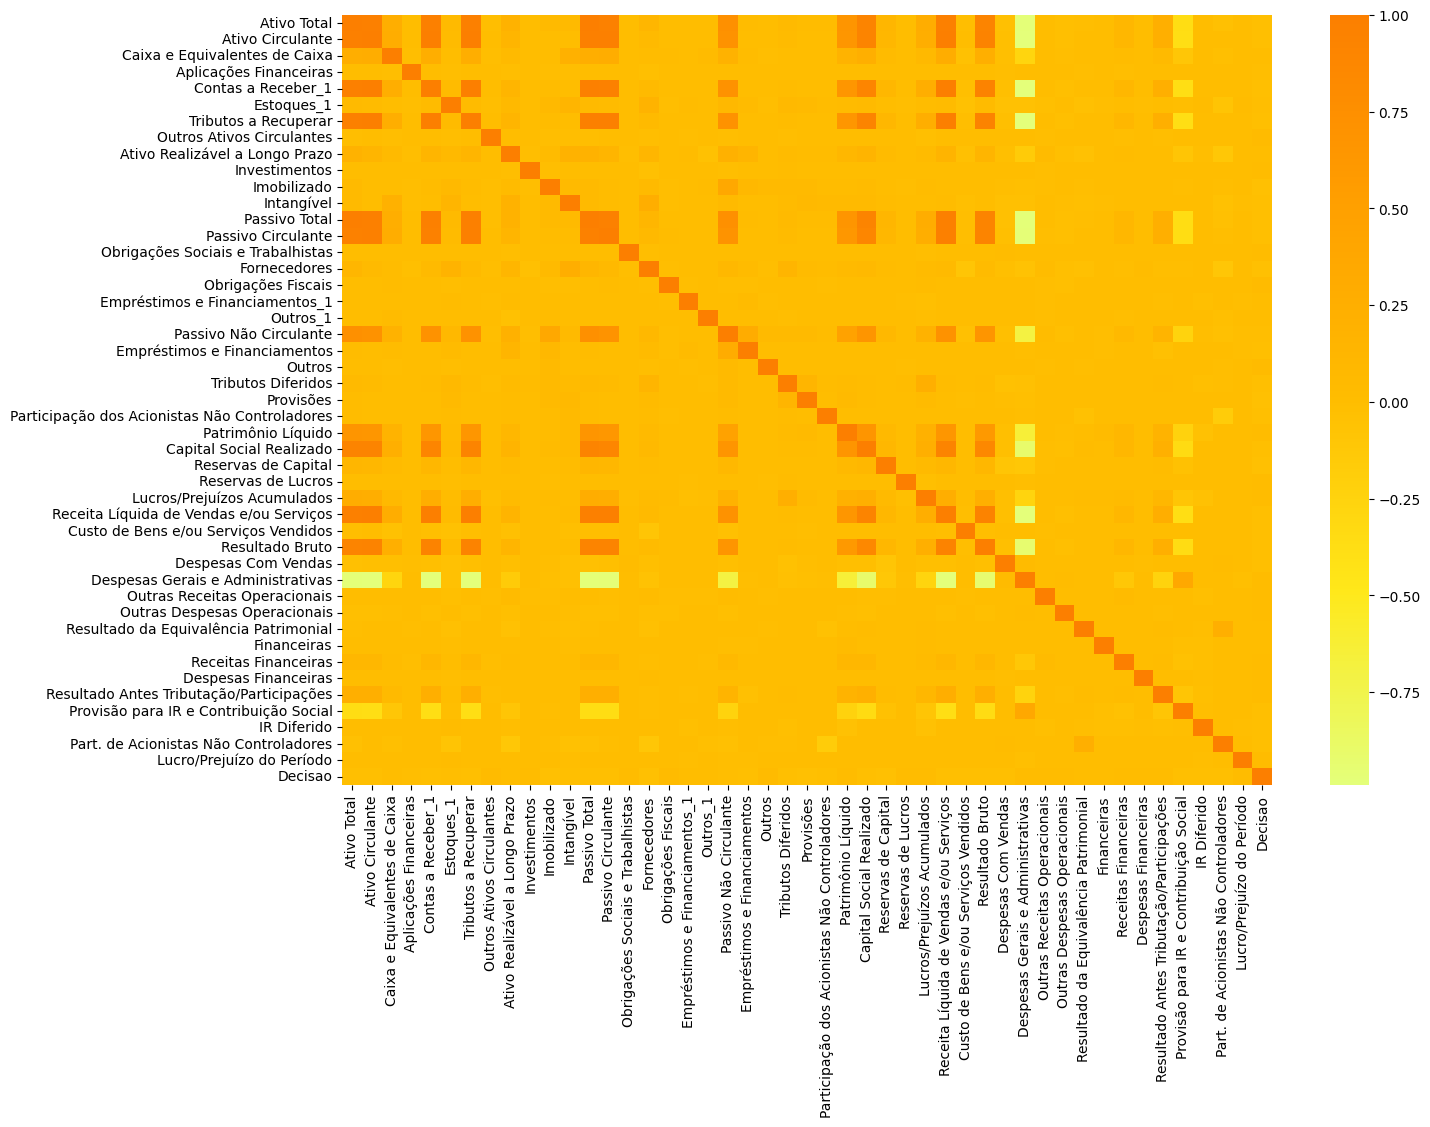

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Tributos a Recuperar,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Investimentos,...,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Decisao
Ativo Total,1.000000,0.990375,0.268207,0.000128,0.986091,0.062906,0.987495,-0.002916,0.188883,-0.001645,...,-0.009751,-0.001334,0.106785,0.000526,0.252992,-0.364361,-0.001726,-0.027517,0.006795,-0.017326
Ativo Circulante,0.990375,1.000000,0.270858,0.001155,0.994335,0.034131,0.996453,-0.000569,0.149521,-0.001403,...,0.000643,0.000133,0.108795,0.000079,0.253536,-0.368647,0.000549,-0.002361,0.007591,-0.017160
Caixa e Equivalentes de Caixa,0.268207,0.270858,1.000000,-0.003437,0.263484,0.006741,0.263830,-0.003842,0.051394,-0.002192,...,0.003791,0.007362,0.027540,0.001309,0.065949,-0.097494,-0.000789,-0.017027,0.001544,0.005398
Aplicações Financeiras,0.000128,0.001155,-0.003437,1.000000,-0.000146,-0.004085,-0.000329,-0.001795,-0.008700,-0.000041,...,-0.007843,-0.001289,-0.003596,0.001087,-0.001519,0.001161,-0.000574,0.001966,-0.000954,-0.008353
Contas a Receber_1,0.986091,0.994335,0.263484,-0.000146,1.000000,0.032876,0.996606,-0.001183,0.152871,-0.000901,...,0.001229,0.000124,0.109124,0.000318,0.252636,-0.370150,0.001276,-0.001767,0.007273,-0.018245
Estoques_1,0.062906,0.034131,0.006741,-0.004085,0.032876,1.000000,0.034865,-0.003720,0.068008,-0.000015,...,-0.031875,-0.007124,0.004024,-0.002783,-0.000398,-0.009014,0.014940,-0.079475,0.018431,-0.004776
Tributos a Recuperar,0.987495,0.996453,0.263830,-0.000329,0.996606,0.034865,1.000000,-0.000563,0.150668,-0.000458,...,0.002269,-0.000395,0.108831,0.000345,0.252485,-0.371240,0.001153,-0.000497,0.006924,-0.021720
Outros Ativos Circulantes,-0.002916,-0.000569,-0.003842,-0.001795,-0.001183,-0.003720,-0.000563,1.000000,-0.002060,-0.000798,...,0.002832,0.000676,-0.004130,0.000668,-0.002723,0.000903,0.001743,0.000956,-0.001062,0.029916
Ativo Realizável a Longo Prazo,0.188883,0.149521,0.051394,-0.008700,0.152871,0.068008,0.150668,-0.002060,1.000000,-0.009513,...,-0.041627,0.002830,0.020674,0.001431,0.008089,-0.091361,-0.006828,-0.104723,0.009486,0.009589
Investimentos,-0.001645,-0.001403,-0.002192,-0.000041,-0.000901,-0.000015,-0.000458,-0.000798,-0.009513,1.000000,...,0.001875,0.002309,-0.001891,0.000614,-0.001125,0.000031,-0.000795,-0.000174,-0.000749,0.020078


In [ ]:
# análise de correlação
correlacoes = base_dados.corr()

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(correlacoes, cmap="Wistia", ax=ax)
plt.show()
display(correlacoes)

In [ ]:
# visualização de campos que possuem a correlação acima de 0,8
correlacoes_encontradas = []
for coluna in correlacoes:
    for linha in correlacoes.index:
        if linha != coluna:
            valor = abs(correlacoes.loc[linha, coluna])
            if valor > 0.8 and (coluna, linha, valor) not in correlacoes_encontradas:
                correlacoes_encontradas.append((linha, coluna, valor))
                print(f"Correlação Encontrada: {linha} e {coluna}. Valor: {valor}")

Correlação Encontrada: Ativo Circulante e Ativo Total. Valor: 0.9903752343838523
Correlação Encontrada: Contas a Receber_1 e Ativo Total. Valor: 0.9860906003995917
Correlação Encontrada: Tributos a Recuperar e Ativo Total. Valor: 0.9874952304707055
Correlação Encontrada: Passivo Total e Ativo Total. Valor: 1.0
Correlação Encontrada: Passivo Circulante e Ativo Total. Valor: 0.9715408979062216
Correlação Encontrada: Capital Social Realizado e Ativo Total. Valor: 0.9235648388541128
Correlação Encontrada: Receita Líquida de Vendas e/ou Serviços e Ativo Total. Valor: 0.9877579258444966
Correlação Encontrada: Resultado Bruto e Ativo Total. Valor: 0.9251950787195677
Correlação Encontrada: Despesas Gerais e Administrativas e Ativo Total. Valor: 0.9788579996885938
Correlação Encontrada: Contas a Receber_1 e Ativo Circulante. Valor: 0.9943352682038928
Correlação Encontrada: Tributos a Recuperar e Ativo Circulante. Valor: 0.9964530874945596
Correlação Encontrada: Passivo Total e Ativo Circulante.

In [ ]:
# eliminação de campos que apresentaram alta taxa de correlação
remover = ['Ativo Circulante', 'Contas a Receber_1', 'Tributos a Recuperar', 'Passivo Total', 'Passivo Circulante', 'Patrimônio Líquido', 'Capital Social Realizado', 'Receita Líquida de Vendas e/ou Serviços', 'Resultado Bruto', 'Despesas Gerais e Administrativas']
base_dados = base_dados.drop(remover, axis=1)

In [ ]:
print(base_dados.shape)

(2232, 37)


In [ ]:
# seleção de features
modelo = ExtraTreesClassifier(random_state=1)
x = base_dados.drop("Decisao", axis=1)
y = base_dados["Decisao"]
modelo.fit(x, y)

caracteristicas_importantes = pd.DataFrame(modelo.feature_importances_, x.columns).sort_values(by=0, ascending=False)
display(caracteristicas_importantes)
top10 = list(caracteristicas_importantes.index)[:10]
print(top10)

,0
Lucros/Prejuízos Acumulados,0.031551
Outros Ativos Circulantes,0.030856
Custo de Bens e/ou Serviços Vendidos,0.030447
Fornecedores,0.030291
Resultado Antes Tributação/Participações,0.029870
Receitas Financeiras,0.029751
Obrigações Fiscais,0.029649
Resultado da Equivalência Patrimonial,0.029419
Estoques_1,0.029331
Lucro/Prejuízo do Período,0.029319


['Lucros/Prejuízos Acumulados', 'Outros Ativos Circulantes', 'Custo de Bens e/ou Serviços Vendidos', 'Fornecedores', 'Resultado Antes Tributação/Participações', 'Receitas Financeiras', 'Obrigações Fiscais', 'Resultado da Equivalência Patrimonial', 'Estoques_1', 'Lucro/Prejuízo do Período']


### Passo 10
Normalização dos dados

In [ ]:
# função para aplicar a normalização
def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("Decisao", axis=1)

    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["Decisao"] = tabela_original["Decisao"]
    return tabela_auxiliar

# aplicação da normalização
nova_base_dados = ajustar_scaler(base_dados)
top10.append("Decisao")

# seleção apenas dos 10 campos mais relevantes
nova_base_dados = nova_base_dados[top10].reset_index(drop=True)
display(nova_base_dados)

,Lucros/Prejuízos Acumulados,Outros Ativos Circulantes,Custo de Bens e/ou Serviços Vendidos,Fornecedores,Resultado Antes Tributação/Participações,Receitas Financeiras,Obrigações Fiscais,Resultado da Equivalência Patrimonial,Estoques_1,Lucro/Prejuízo do Período,Decisao
0,0.222854,-0.031715,0.033271,-0.150520,-0.040094,-0.062783,-0.044947,-0.013596,-0.092103,-0.031282,2
1,12.399849,-0.024950,-0.137540,2.192047,11.938748,5.146090,0.010871,0.110264,1.607297,0.334373,0
2,0.116969,-0.030466,0.019756,0.145542,-0.024566,-0.030355,-0.045835,4.832296,-0.179191,-0.028109,2
3,-0.460505,-0.030372,-0.153584,0.862737,0.038988,0.113943,-0.022911,0.098999,0.045181,-0.026040,2
4,0.222854,-0.030179,0.117516,-0.474799,-0.070769,-0.113280,-0.047305,-0.006261,0.070091,-0.033118,0
...,...,...,...,...,...,...,...,...,...,...,...
2227,-0.460505,-0.030284,0.019070,-0.759231,-0.089840,-0.100217,-0.029531,-0.013596,-0.092103,-0.034437,0
2228,0.222854,-0.032632,0.057570,0.726993,0.009652,0.165651,-0.061558,-0.013596,-0.092103,-0.028126,0
2229,-0.404988,-0.029646,0.009103,-0.606149,-0.089840,-0.138992,-0.047199,-0.013596,-0.092103,-0.034437,0
2230,0.285631,-0.031569,0.050329,-0.052246,0.009652,0.013425,-0.043785,-0.013596,-0.092103,-0.028126,0


### Passo 11
Separação dos dados em treino e teste

In [ ]:
x = nova_base_dados.drop("Decisao", axis=1)
y = nova_base_dados["Decisao"]

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=1)

### Passo 12
Criação de um Dummy Classifier, para avaliar recomendações feitas por puro "chute"

In [ ]:
dummy = DummyClassifier(strategy="stratified", random_state=2)
dummy.fit(x_treino, y_treino)
previsao_dummy = dummy.predict(x_teste)

Dummy
              precision    recall  f1-score   support

           0       0.52      0.53      0.52       286
           2       0.50      0.49      0.49       272

    accuracy                           0.51       558
   macro avg       0.51      0.51      0.51       558
weighted avg       0.51      0.51      0.51       558



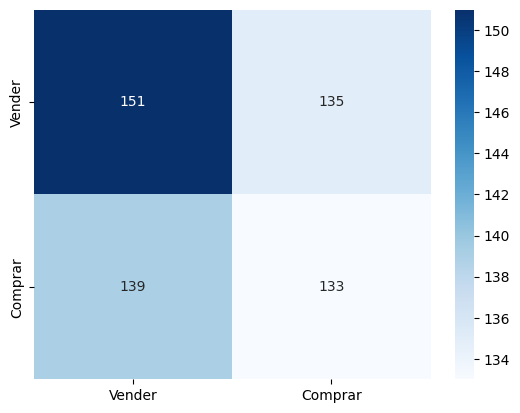

##################################################


In [ ]:
def avaliar(y_teste, previsoes, nome_modelo):
    print(nome_modelo)
    report = classification_report(y_teste, previsoes)
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, previsoes), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("#" * 50)


avaliar(y_teste, previsao_dummy, "Dummy")

### Passo 13
Testes de diferentes tipos de modelo para de avaliar diferentes resultados

In [ ]:
# dicionário com diferentes tipos de modelos
modelos = {
    "AdaBoost": AdaBoostClassifier(random_state=1),
    "DecisionTree": DecisionTreeClassifier(random_state=1),
    "RandomForest": RandomForestClassifier(random_state=1),
    "ExtraTree": ExtraTreesClassifier(random_state=1),
    "GradientBoost": GradientBoostingClassifier(random_state=1),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(random_state=1),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(random_state=1),
    "RedeNeural": MLPClassifier(random_state=1, max_iter=400),
}

AdaBoost
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       286
           2       0.55      0.50      0.52       272

    accuracy                           0.55       558
   macro avg       0.55      0.55      0.55       558
weighted avg       0.55      0.55      0.55       558



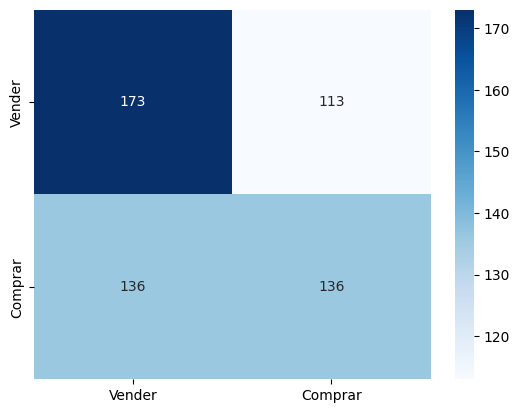

##################################################
DecisionTree
              precision    recall  f1-score   support

           0       0.57      0.53      0.55       286
           2       0.54      0.58      0.56       272

    accuracy                           0.55       558
   macro avg       0.55      0.55      0.55       558
weighted avg       0.55      0.55      0.55       558



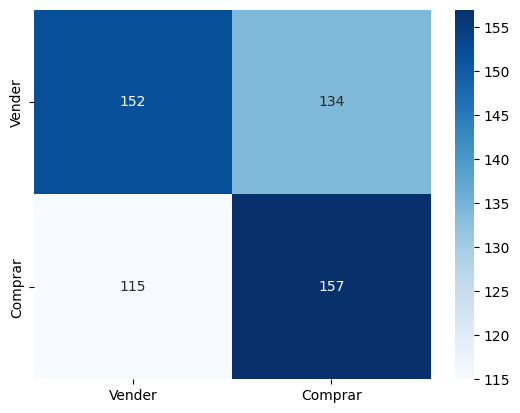

##################################################
RandomForest
              precision    recall  f1-score   support

           0       0.56      0.61      0.59       286
           2       0.55      0.50      0.52       272

    accuracy                           0.56       558
   macro avg       0.55      0.55      0.55       558
weighted avg       0.55      0.56      0.55       558



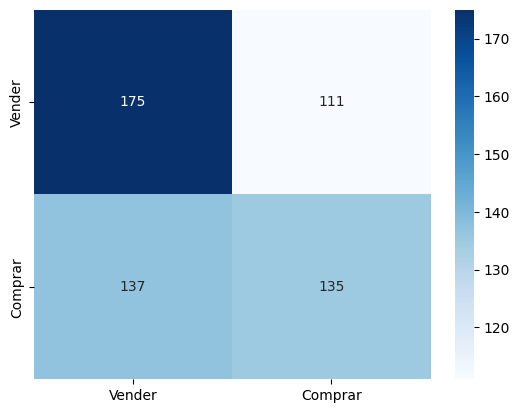

##################################################
ExtraTree
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       286
           2       0.59      0.50      0.54       272

    accuracy                           0.58       558
   macro avg       0.58      0.58      0.58       558
weighted avg       0.58      0.58      0.58       558



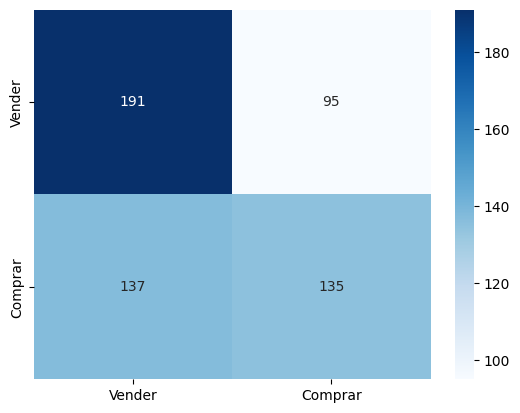

##################################################
GradientBoost
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       286
           2       0.56      0.52      0.54       272

    accuracy                           0.57       558
   macro avg       0.57      0.57      0.56       558
weighted avg       0.57      0.57      0.57       558



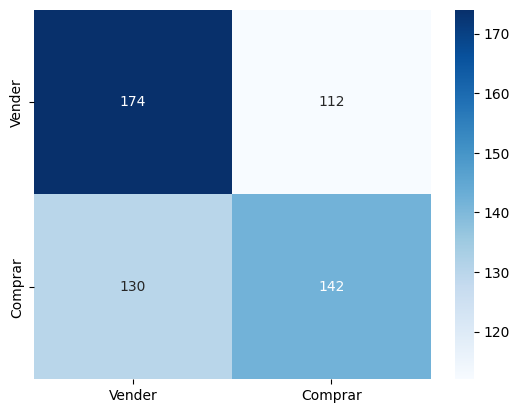

##################################################
KNN
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       286
           2       0.53      0.54      0.54       272

    accuracy                           0.54       558
   macro avg       0.54      0.54      0.54       558
weighted avg       0.54      0.54      0.54       558



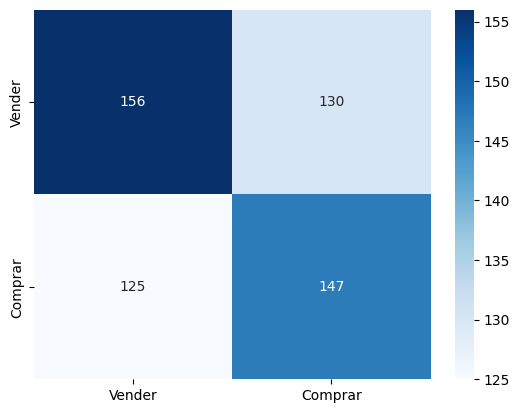

##################################################
LogisticRegression
              precision    recall  f1-score   support

           0       0.54      0.83      0.65       286
           2       0.58      0.25      0.35       272

    accuracy                           0.55       558
   macro avg       0.56      0.54      0.50       558
weighted avg       0.56      0.55      0.51       558



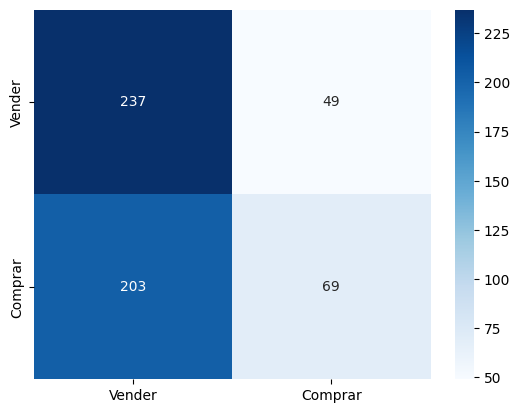

##################################################
NaiveBayes
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       286
           2       0.50      0.03      0.05       272

    accuracy                           0.51       558
   macro avg       0.51      0.50      0.36       558
weighted avg       0.51      0.51      0.37       558



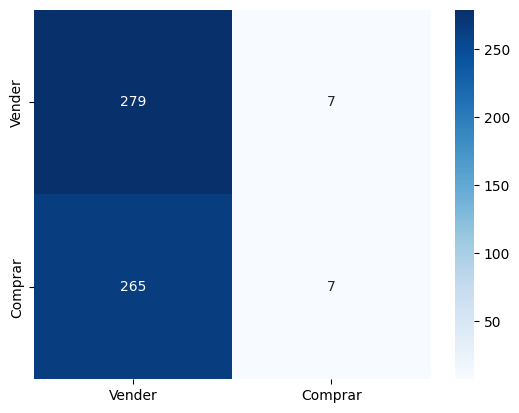

##################################################
SVM
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       286
           2       0.61      0.26      0.37       272

    accuracy                           0.56       558
   macro avg       0.57      0.55      0.51       558
weighted avg       0.57      0.56      0.52       558



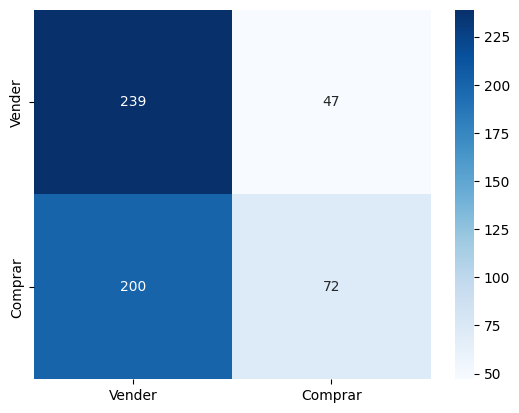

##################################################


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.



RedeNeural
              precision    recall  f1-score   support

           0       0.56      0.64      0.60       286
           2       0.56      0.48      0.51       272

    accuracy                           0.56       558
   macro avg       0.56      0.56      0.56       558
weighted avg       0.56      0.56      0.56       558



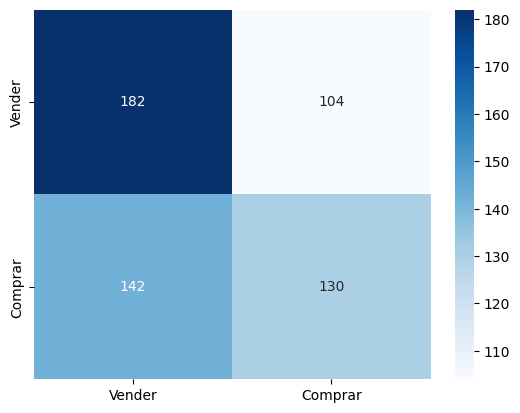

##################################################


In [ ]:
# aplicação dos modelos através de um looping
for nome_modelo in modelos:
    modelo = modelos[nome_modelo]
    modelo.fit(x_treino, y_treino)
    previsoes = modelo.predict(x_teste)
    avaliar(y_teste, previsoes, nome_modelo)
    modelos[nome_modelo] = modelo

### Passo 14
Tunning do modelo escolhido

In [ ]:
# Utilizando a precisão como critério de escolha do modelo,
# optou-se pelo SVM, pois apresenta o valor mais alto nesse indicador em relação aos demais

modelo_final = modelos["SVM"]

# Definir os valores dos parâmetros a serem testados
param_grid = {
    'C': [0.1, 1, 10],  # Valores diferentes para o parâmetro de regularização C
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']  # Testar diferentes opções para o parâmetro gamma
}

# Passo 4: Realizar a busca em grid com validação cruzada
grid_search = GridSearchCV(modelo_final, param_grid, cv=5)  # cv define o número de folds da validação cruzada
grid_search.fit(x_treino, y_treino)

# Passo 5: Obter os melhores parâmetros encontrados
melhores_parametros = grid_search.best_params_

# Passo 6: Criar o modelo SVM com os melhores parâmetros
best_svm_model = SVC(**melhores_parametros)

# Passo 7: Ajustar o modelo ao conjunto de treinamento completo
resultado_grid = best_svm_model.fit(x_treino, y_treino)

SVM Tunado
              precision    recall  f1-score   support

           0       0.54      0.79      0.65       286
           2       0.58      0.30      0.40       272

    accuracy                           0.55       558
   macro avg       0.56      0.55      0.52       558
weighted avg       0.56      0.55      0.52       558



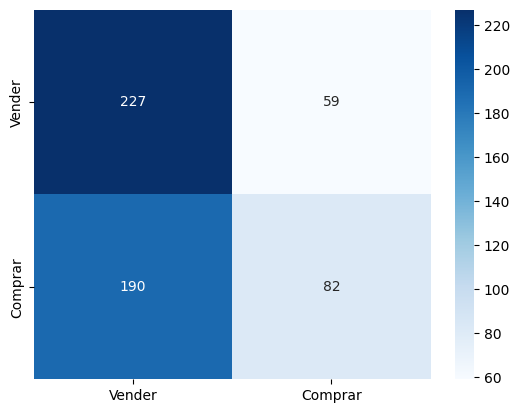

##################################################


In [ ]:
# Análise dos resultados do modelo tunado
previsoes = resultado_grid.predict(x_teste)
avaliar(y_teste, previsoes, "SVM Tunado")

### Passo 15
Avaliar a rentabilidade da carteira com base nas previsões do modelo, utilizando o último trimestre, o qual não foi usado nem no treino e nem no teste

In [ ]:
# Criação da base de dados apenas com os dados do último trimestre
ult_tri_fundamentos = fundamentos.copy()
ult_tri_base_dados = pd.DataFrame()
lista_empresas = []
for empresa in ult_tri_fundamentos:
    ult_tri_fundamentos[empresa] = ult_tri_fundamentos[empresa][-1:]
    ult_tri_fundamentos[empresa] = ult_tri_fundamentos[empresa].reset_index(drop=True)
    ult_tri_base_dados = ult_tri_base_dados.append(ult_tri_fundamentos[empresa])
    lista_empresas.append(empresa)
display(ult_tri_base_dados)
print(lista_empresas)

<ipython-input-127-8df29a785590>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-127-8df29a785590>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-127-8df29a785590>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-127-8df29a785590>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-127-8df29a785590>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-127-8df29a785590>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Tributos a Recuperar,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Investimentos,...,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Decisao
0,-0.018059,-0.064470,-0.181714,-0.196290,-0.056537,0.008346,0.068747,0.233278,0.029444,0.018856,...,0.329676,0.075995,-0.280759,0.175502,-0.103955,-1.000000,1.000000,-0.026998,-0.255150,0
0,-0.070457,-0.189295,-0.302235,0.000000,-0.297614,-0.003975,-0.000609,-0.117180,-0.084984,0.000000,...,0.000000,-1.000000,-0.962095,0.313749,-1.000000,0.000000,0.000000,0.000000,-1.000000,0
0,-0.037575,-0.090510,-0.261628,-0.004190,-0.077128,0.000000,-0.512821,0.373136,-0.034363,-0.004484,...,-1.000000,1.924855,0.361380,-0.127220,0.086017,0.108726,-1.000000,0.296053,0.085195,0
0,-0.057195,-0.258362,-0.353731,0.024622,0.000000,0.000000,0.000000,0.000000,0.122628,0.025339,...,0.000000,-0.361715,-0.361715,0.000000,-0.305245,1.000000,0.000000,0.000000,0.000000,0
0,-0.055081,-0.082776,-0.144322,0.031330,-0.143594,0.051865,-0.095980,0.028617,-0.002397,0.000000,...,0.000000,0.495032,0.168867,0.449178,1.000000,1.000000,-1.000000,1.000000,1.000000,0
0,-0.005481,0.205045,0.915532,0.000000,-1.000000,0.000000,0.000000,0.000000,-0.194363,-0.020607,...,0.131282,-0.253172,-0.238966,-12.035714,0.126583,0.000000,0.000000,0.000000,0.025669,0
0,-0.001930,-0.008145,0.041269,0.011069,-0.112164,-0.034299,0.193352,-0.058996,0.001441,0.001761,...,-1.000000,-0.428569,-0.291464,-0.200204,-0.135919,-1.000000,1.000000,-1.000000,-0.133512,0
0,0.027265,0.063238,-0.006682,0.667777,0.269818,-0.017715,-0.085816,0.000000,-0.029625,0.056622,...,0.516099,0.083233,-0.868549,0.557585,1.000000,-1.000000,0.210913,-1.000000,1.000000,0
0,0.004692,-0.135215,-0.121664,-0.112936,-0.250791,0.000000,-0.105478,0.106949,0.133262,0.333210,...,-0.212010,-0.073023,-1.000000,1.000000,1.000000,-3.483746,0.050846,1.000000,1.000000,0
0,-0.080285,-0.089257,-0.063299,0.070989,-0.107708,0.000000,-0.038845,0.000000,0.015277,0.005604,...,-0.714302,0.472305,0.292017,-0.008396,58.391761,-1.000000,0.563519,0.000000,-0.093091,0


['ABEV3', 'AZUL4', 'B3SA3', 'BBSE3', 'BEEF3', 'BRAP4', 'BRFS3', 'BRKM5', 'CCRO3', 'CIEL3', 'CMIG4', 'COGN3', 'CPFE3', 'CPLE6', 'CRFB3', 'CSAN3', 'CVCB3', 'CYRE3', 'ECOR3', 'EGIE3', 'ELET6', 'EMBR3', 'ENBR3', 'ENEV3', 'ENGI11', 'EQTL3', 'FLRY3', 'GGBR4', 'GOAU4', 'GOLL4', 'HAPV3', 'HYPE3', 'ITSA4', 'JBSS3', 'JHSF3', 'KLBN11', 'LREN3', 'MGLU3', 'MRFG3', 'MRVE3', 'MULT3', 'NTCO3', 'PCAR3', 'PETR4', 'PRIO3', 'QUAL3', 'RADL3', 'RAIL3', 'RENT3', 'SBSP3', 'SUZB3', 'TAEE11', 'TIMS3', 'TOTS3', 'UGPA3', 'USIM5', 'VALE3', 'VIVT3', 'WEGE3', 'YDUQ3']


In [ ]:
# Ajuste da nova base de dados de acordo com os mesmos tratamentos feitos na anterior
ult_tri_base_dados = ult_tri_base_dados.reset_index(drop=True)
ult_tri_base_dados = ult_tri_base_dados[top10]
ult_tri_base_dados = ajustar_scaler(ult_tri_base_dados)
ult_tri_base_dados = ult_tri_base_dados.drop("Decisao", axis=1)
display(ult_tri_base_dados)

,Lucros/Prejuízos Acumulados,Outros Ativos Circulantes,Custo de Bens e/ou Serviços Vendidos,Fornecedores,Resultado Antes Tributação/Participações,Receitas Financeiras,Obrigações Fiscais,Resultado da Equivalência Patrimonial,Estoques_1,Lucro/Prejuízo do Período
0,0.669511,0.406351,0.120248,-0.286563,-0.192257,-0.716858,-0.509061,-0.019979,-0.069277,-0.183072
1,-0.671480,-0.461693,-0.850511,1.466424,-0.311545,-1.579851,-0.475642,-0.153013,-0.191691,-0.385618
2,0.669511,0.752766,1.666972,0.161396,-0.166967,0.096487,-0.810142,-0.556543,-0.152197,-0.090522
3,0.669511,-0.171451,-0.081866,0.613172,-0.219055,-0.819398,-0.104751,-0.153013,-0.152197,-0.113689
4,0.669511,-0.100571,0.048912,-1.195687,-0.045291,-0.147353,-0.535701,-0.153013,0.363107,0.158240
5,0.669511,-0.171451,-0.081866,0.613172,-0.161567,-0.663923,-0.908274,-0.100037,-0.152197,-0.106709
6,-1.199151,-0.317577,0.092190,0.302591,-0.196513,-0.730418,-0.212483,-0.556543,-0.492974,-0.149995
7,0.669511,-0.171451,0.000916,0.611027,-0.045291,-1.461364,0.007648,0.055248,-0.328209,0.158240
8,0.669511,0.093450,0.328549,-1.558211,-0.045291,-1.627862,-0.510754,-0.238566,-0.152197,0.158240
9,-0.630361,-0.171451,-2.683037,-0.092746,7.595103,0.008630,-0.308359,-0.441256,-0.152197,-0.139003


In [ ]:
previsoes_ult_tri = resultado_grid.predict(ult_tri_base_dados)
print(previsoes_ult_tri)

carteira = []
carteira_inicial = []

# simulação de carteira, caso fosse investido R$1.000,00 para cada ação que o modelo recomendou comprar
for i, empresa in enumerate(lista_empresas):
    if previsoes_ult_tri[i] == 2:
        print(empresa)
        carteira_inicial.append(1000)
        cotacao = cotacoes[empresa]
        cotacao = cotacao.set_index("Date")
        cotacao_inicial = cotacao.loc["2022-12-31", "Adj Close"]
        cotacao_final = cotacao.loc["2023-03-31", "Adj Close"]
        percentual = cotacao_final / cotacao_inicial
        carteira.append(1000 * percentual)

saldo_inicial = sum(carteira_inicial)
saldo_final = sum(carteira)

[0 0 2 0 2 0 0 0 2 0 2 0 2 0 2 2 2 0 2 2 0 2 2 0 0 0 2 2 2 2 2 0 0 2 0 0 2
 2 2 0 2 2 0 2 0 2 2 0 2 2 2 2 0 0 2 2 0 2 2 2]
B3SA3
BEEF3
CCRO3
CMIG4
CPFE3
CRFB3
CSAN3
CVCB3
ECOR3
EGIE3
EMBR3
ENBR3
FLRY3
GGBR4
GOAU4
GOLL4
HAPV3
JBSS3
LREN3
MGLU3
MRFG3
MULT3
NTCO3
PETR4
QUAL3
RADL3
RENT3
SBSP3
SUZB3
TAEE11
UGPA3
USIM5
VIVT3
WEGE3
YDUQ3


In [ ]:
print('Saldo inicial x Saldo final')
print(f'R${round(saldo_inicial,2)} x R${round(saldo_final,2)}')
print('')
print('Variação da carteira')
print(round(saldo_final / saldo_inicial,2))

Saldo inicial x Saldo final
R$35000 x R$33426.04

Variação da carteira
0.96


In [ ]:
# comparação com a variação do IBOV no mesmo período
variacao_ibov = df_ibov.loc["2023-03-31", "IBOV"] / df_ibov.loc["2022-12-31", "IBOV"]
print(round(variacao_ibov,2))

0.93


###Resutado final:
Apesar da carteira não ter sido lucrativa no período de um trimestre, ainda assim ela rendeu mais (ou na verdade, perdeu menos valor) que o índice Ibovespa, o que pode ser indicativo de que a carteira possa ser rentável a longo prazo. Porém, mais testes precisam ser feitos e novos períodos precisam ser avaliados para chegar a uma conclusão mais consistente.